#Step 0 - Gdrive mount & Import Libararies

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
data_dir = gdrive_root+'/ai_emotion'
#data_dir = '.'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2

from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

import torchvision
from torchvision import transforms, utils, datasets

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


#Step 1 - data file load

##1.1 - Dataset class construction

* Input : **csv_file** - path to csv_file (train, validation, test), **root_dir** - path to save image, **transform** - preprocess
* reference: https://blog.naver.com/PostView.nhn?blogId=keum_zz6&logNo=221610967175&parentCategoryNo=&categoryNo=15&viewDate=&isShowPopularPosts=true&from=search

* data: http://pics.psych.stir.ac.uk/2D_face_sets.htm

In [0]:
class EmotionDataset(Dataset): #Dataset class that load data from csv file
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.faces, self.emotions = self.load_fer2013(csv_file) # load pixel matrixs & labels form csv file

    def __len__(self):
        return self.emotions.shape[0]

    def __getitem__(self, idx):
        label_list = self.emotions[idx].tolist() 
        label = label_list.index(1) # load label
        image = self.faces[idx] # load image numpy matrix
        image = np.transpose(image, (2, 0, 1)) 
        image = image.squeeze(0) # resize the dimension of image
        pil_img = Image.fromarray(image) # convert PIL image from numpy array 
        pil_img = pil_img.convert('L') # convert gray scale image
        if self.transform:
            image = self.transform(pil_img) # additional preprocess
        image = image.to(device, torch.float) 
        return image, label

    def load_fer2013(self, dataset_path):
        image_size=(48,48)
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).as_matrix()
        return faces, emotions

In [0]:
def imshow(tensor): 
  unloader = transforms.ToPILImage()
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  plt.pause(0.001)

##1.2 - Preprocess definition

* image size = 224 x 224
* center crop & tensor

In [0]:
imsize = 48 
preprocess = transforms.Compose([
  transforms.Resize(imsize),            # fixed size for both content and style images
  transforms.CenterCrop(imsize),        # crops the given PIL Image at the center.
  transforms.ToTensor(),                # range between 0 and 1
])

##1.3 load dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


len(train): 29103, len(valid): 3653, len(test): 3589
0 torch.Size([1, 48, 48]) Neutral


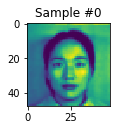

1 torch.Size([1, 48, 48]) Fear


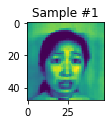

2 torch.Size([1, 48, 48]) Surprise


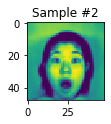

3 torch.Size([1, 48, 48]) Happy


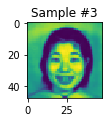

In [6]:
trainset = EmotionDataset(csv_file=data_dir+'/new_train.csv', transform=preprocess) #load the train set
validset = EmotionDataset(csv_file=data_dir+'/new_valid.csv', transform=preprocess) #load the validation set
testset = EmotionDataset(csv_file=data_dir+'/test.csv', transform=preprocess) #load test set

emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'} # dictionary of emotion

print('len(train): %d, len(valid): %d, len(test): %d' %(len(trainset), len(validset), len(testset)))

## example image show ##
fig = plt.figure()
j = 0
for i in range(len(trainset)):
    img, label = trainset[i]
    print(i, img.shape, emotion[label])

    ax = plt.subplot(1, 4, j + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    imshow(img)
    ax.axis('off')

    if j == 3:
        plt.show()
        break
    j += 1

#Step 2 - Separate training & test set

In [0]:
batch_size = 32
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=0)

#Step 3 - Model construction

* Using VGG19
* Loss = cross entropy & Optimizer = Adam
* Reference 1): https://poddeeplearning.readthedocs.io/ko/latest/CNN/VGG19%20+%20GAP%20+%20CAM/
* Reference 2): https://medium.com/@inmoonlight/pytorch%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-cnn-62a9326111ae



##3.1 - Model class

In [0]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 1),
            nn.MaxPool2d(2, 1),
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(512),
        )

        #512 7 4
        self.avg_pool = nn.AvgPool2d(7)

        #512 8 1
        self.classifier = nn.Linear(512, 7)
        self.softmax = nn.Softmax()

    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

##3.2 - Model load

In [0]:
model = VGGNet()
model = model.to(device)
learning_rate = 0.008
optimizer = optim.Adam(model.parameters(),lr=learning_rate) # using Adam

#Step 4 - Model training

* reference 1): https://hoya012.github.io/blog/DenseNet-Tutorial-2/
* reference 2): https://github.com/developer0hye/Custom-CNN-based-Image-Classification-in-PyTorch

##4.1 - Load pre-trained weights

In [10]:
ckpt_dir = os.path.join(data_dir, 'checkpoints') # directory of checkpoint
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

best_acc = 0.

ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.66


##4.2 - Set state & epoch

In [11]:
training_process = False # ON & OFF switch of training process
epochs = 20 # epoch
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://f606b28d.ngrok.io


##4.3 - Training process

* Training from train_loader
* Validation check from valid_loader
* If valid_acc > best_acc: save new checkpoint

###4.3.1 - Training function

In [0]:
def train_model(model, optimizer, train_loader, valid_loader, ckpt_path, tbc, epochs=20):
    best_acc = 0.0
    if os.path.exists(ckpt_path): # load the checkpoint data
        ckpt = torch.load(ckpt_path)
        best_acc = ckpt['best_acc']
    it = 0
    for epoch in range(epochs):
        model.train() # change to training mode
        batch = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            it += 1
            batch += 1
            outputs = model(inputs) # predicted datas
            loss = F.cross_entropy(outputs, labels) # loss function == cross entropy
            optimizer.zero_grad()
            loss.backward() # backprop

            optimizer.step()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            if batch % 50 == 0:
                tbc.save_value('Loss', 'train_loss', it, loss.item())
                print("epoch : %d, batch : %d, train_loss: %f, acc: %f" %(epoch+1, batch, loss.item(), acc.item()))

        # validation phase
        if valid_loader: # task activation if there is validation set
            n = 0.
            valid_loss = 0.
            valid_acc = 0.
            model.eval() # change to evaluation mode
            for valid_inputs, valid_labels in valid_loader:
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_outputs = model(valid_inputs)
                valid_loss += F.cross_entropy(valid_outputs, valid_labels, reduction='sum').item() # loss calculation
                valid_acc += (valid_outputs.argmax(dim=1) == valid_labels).float().sum().item() # accuracy calculation
                n += valid_inputs.size(0)

            valid_loss /= n
            valid_acc /= n
            tbc.save_value('Loss', 'valid_loss', it, valid_loss)
            print('[epoch:{}, iteration:{}] valid_loss : {:.4f} valid accuracy : {:.4f}'.format(epoch+1, it, valid_loss, valid_acc)) 

            tbc.flush_line('train_loss')
            tbc.flush_line('valid_loss')

            # save checkpoint whenever there is improvement in performance
            if valid_acc > best_acc:
                best_acc = valid_acc
                # Note: optimizer also has states ! don't forget to save them as well.
                ckpt = {'model':model.state_dict(), # save model weight
                        'optimizer':optimizer.state_dict(), 
                        'best_acc':best_acc}
                torch.save(ckpt, ckpt_path)
                print('checkpoint is saved !')
            
    tbc.close()
    model.load_state_dict(ckpt['model'])
    return model

###4.3.2 - Model training

In [0]:
if training_process: 
    model = train_model(model=model, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, ckpt_path=ckpt_path, tbc=tbc, epochs=20)

#Step 5 - Model evaluation

##5.1 - Accuracy test

###5.1.1 - Overall accuracy

In [0]:
model.load_state_dict(ckpt['model']) # load weight on best accuracy
model.eval() # change to evaluation mode

if test_loader:
    n, avg_loss, avg_acc = 0., 0., 0.

    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs) 
        test_loss = F.cross_entropy(test_outputs, test_labels, reduction='sum').item() # calculate loss
        test_pres = test_outputs.argmax(dim=1) # predicted data
        test_acc = (test_pres == test_labels).float().sum().item() 
        avg_loss += test_loss # add each loss
        avg_acc += test_acc # add each acc
        n += test_inputs.size(0)

    avg_loss /= n # avg. loss
    avg_acc /= n # avg. acc
    print('average loss of test : {:.4f} average accuracy of test : {:.4f}'.format(avg_loss, avg_acc)) 

###5.1.2 - Accuracy of each class

In [0]:
label_array, predict_array = test_labels.cpu().numpy(), test_pres.cpu().numpy()
label_array, predict_array = label_binarize(label_array, [0,1,2,3,4,5,6]), label_binarize(predict_array, [0,1,2,3,4,5,6]) # binarize label

for i in range(label_array.shape[1]):
    for j in range(label_array.shape[0]):
        if predict_array[j,i] != label_array[j,i]:
            predict_array[j,i] = 0

class_acc = [] # list containing accuray of each class
for i in range(label_array.shape[1]):
    class_acc.append(predict_array[:,i].sum()/label_array[:,i].sum()*100)

print(class_acc)
print(sum(class_acc)/len(class_acc))

###5.1.3 - Result plot

In [0]:
emotion_list = list(emotion.values())
emotion_list_avg = emotion_list + ['average']
class_acc_avg = class_acc + [avg_acc]

plt.figure()
plt.bar(emotion_list_avg, class_acc_avg, color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Accuracy')
plt.title('Accuracy of each class')
plt.show()

##5.2 - ROC Curve & AUC score

###5.2.1 - Calculate AUC score of ROC curve

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
label_array, predict_array = test_labels.cpu().numpy(), test_pres.cpu().numpy()
label_array, predict_array = label_binarize(label_array, range(7)), label_binarize(predict_array, range(7))

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(label_array[:, i], predict_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

###5.2.2 - Draw the ROC curve

In [0]:
for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Emotion classificaion - ROC curve : %s' %(emotion[i]))
    plt.legend(loc="lower right")
    plt.show()

##5.3 - Single random example test

In [0]:
img, label = testset[50]
model.eval()
test_prediction = F.softmax(model(img.unsqueeze(0).to(device))).argmax().item()
print(test_prediction)

##5.4 - Save the result matrix

In [0]:
emotion_str1 = ','.join(emotion_list_avg)
emotion_str2 = ','.join(emotion_list)
roc_list = list(roc_auc.values())
class_str = ','.join(list(map(str, class_acc_avg)))

tpr_list =[]
fpr_list =[]

for i in range(7):
    tpr_list.append(tpr[i][1])
    fpr_list.append(fpr[i][1])

tpr_str = ','.join(list(map(str, tpr_list)))
fpr_str = ','.join(list(map(str, fpr_list)))
roc_str = ','.join(list(map(str, roc_list)))

csv_file = open(data_dir+'/Emotion_result.csv', 'w')
csv_file.write(emotion_str1+'\n'+class_str+'\n')
csv_file.write('\n')

csv_file.write(emotion_str2+'\n'+tpr_str+'\n'+fpr_str+'\n'+roc_str)
csv_file.close()